In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Acquire

In [2]:
def wrangle_temp_by_state():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run 
    the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'GlobalLandTemperaturesByState.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        
    return df

In [3]:
df = wrangle_temp_by_state()

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


# Prep

In [5]:
#change data type on Date
df.dt = df.dt.astype('datetime64[ns]')

In [6]:
#set the index to Date
df = df.set_index('dt').sort_index()

In [7]:
# check head
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [8]:
#rename columns
df = df.rename(columns={'AverageTemperature':'average_temp', 
                        'AverageTemperatureUncertainty':'average_temp_uncertainty', 
                        'State':'state','Country':'country'})
    

In [9]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [10]:
# rename index
df.index.names = ['date']

In [11]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
date,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [12]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              620027 non-null  float64
 1   average_temp_uncertainty  620027 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [17]:
# fill them
df = df.fillna(0)

In [18]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              645675 non-null  float64
 1   average_temp_uncertainty  645675 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [19]:
#create new colum for month
df['month'] = df.index.month_name()
#create new colum for weekday
df['day_of_week'] = df.index.day_name()
#create new column for year
df['year'] = df.index.year

In [20]:
# check final clean up
df.head()

,average_temp,average_temp_uncertainty,state,country,month,day_of_week,year
date,,,,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada,November,Friday,1743
1743-11-01,0.753,2.817,Michigan,United States,November,Friday,1743
1743-11-01,0.665,2.208,Prince Edward Island,Canada,November,Friday,1743
1743-11-01,-0.526,2.304,Pskov,Russia,November,Friday,1743
1743-11-01,1.891,1.718,Massachusetts,United States,November,Friday,1743


In [22]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 1743-11-01 00:00:00 to 2013-09-01 00:00:00
Shape: (645675, 7)


# Split 

In [23]:
train_len = int(0.6 * len(df))
val_test_split = int(0.8 * len(df))
train_len, val_test_split

(387405, 516540)

In [24]:
train = df.iloc[:train_len]
val = df.iloc[train_len:val_test_split]
test = df.iloc[val_test_split:]
train.shape, val.shape, test.shape

((387405, 7), (129135, 7), (129135, 7))

In [25]:
def plot_distributions(df):
    for col in list(df.columns):
        plt.figure()
        sns.histplot(df[col])
        plt.title('Distribution of {}'.format(col))

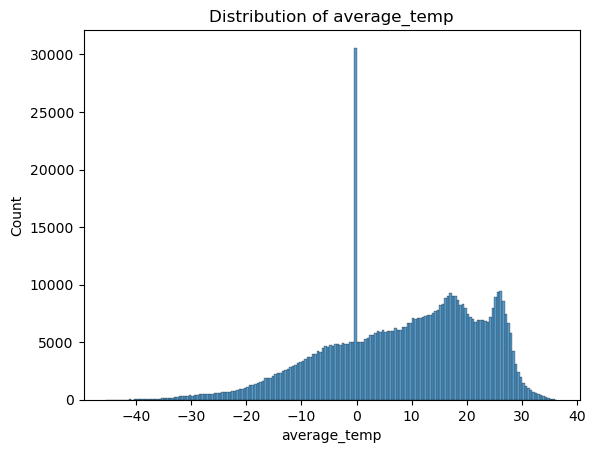

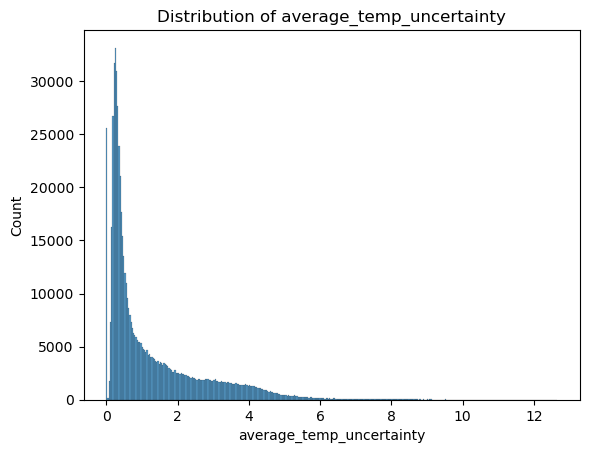

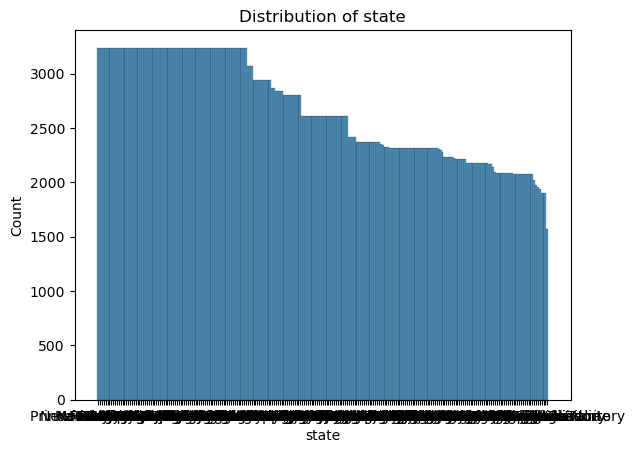

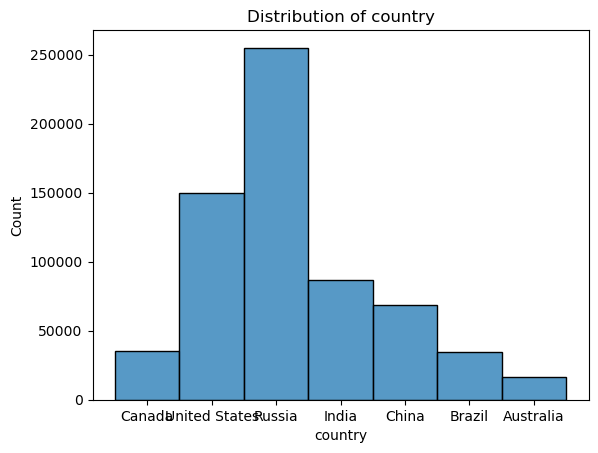

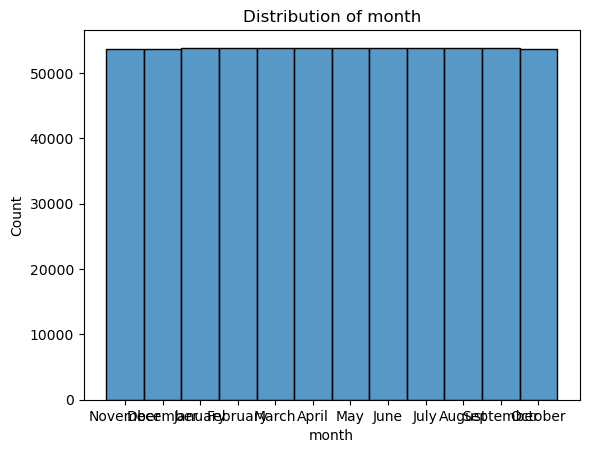

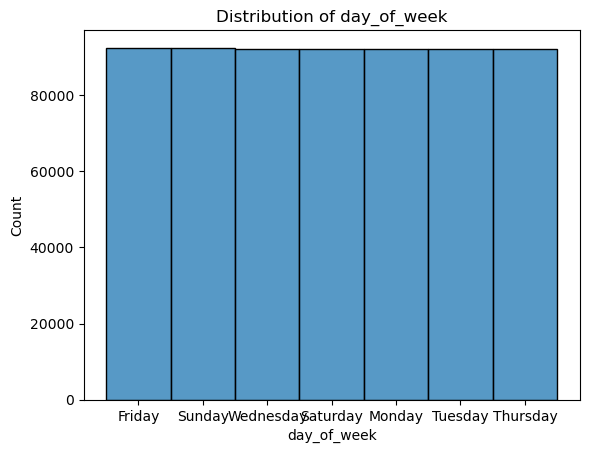

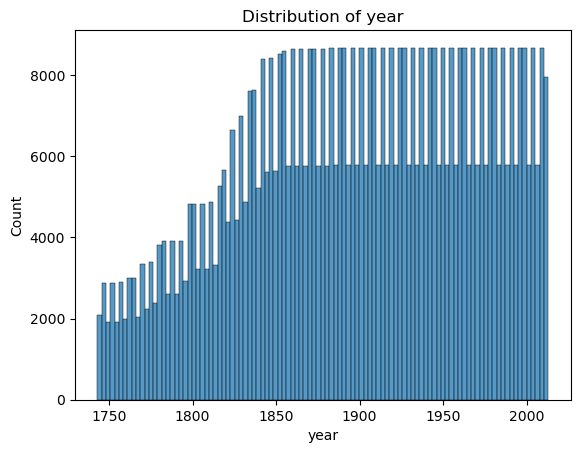

In [26]:
plot_distributions(df)

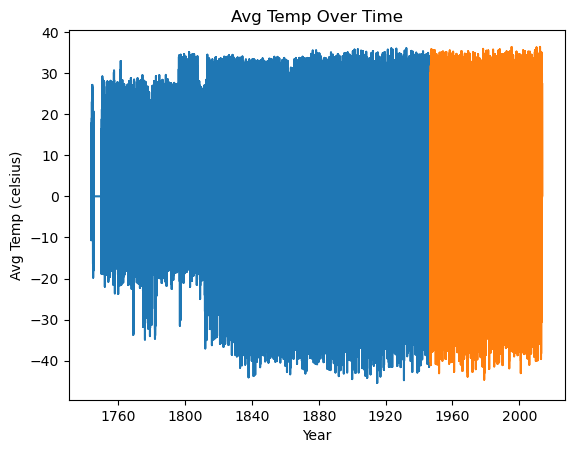

In [34]:
#plot train with target of average temp
#use percentage-based data split
train_size = .70

#n is the entire number of entries in the dataframe
n = df.shape[0]

#look at what n is (total entries in the df)
n
#set the test size to 70% * total number of entries 
test_start_index = round(train_size * n)

#take a look (70% of entire df)
test_start_index
#everything up (not including) to the test_start_index
perc_train = df[:test_start_index]

#everything from the test_start_index to the end
perc_test = df[test_start_index:] 
plt.plot(perc_train.index, perc_train.average_temp)
#plot test with target of sale amount
plt.plot(perc_test.index, perc_test.average_temp)

plt.title('Avg Temp Over Time')

plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')

None

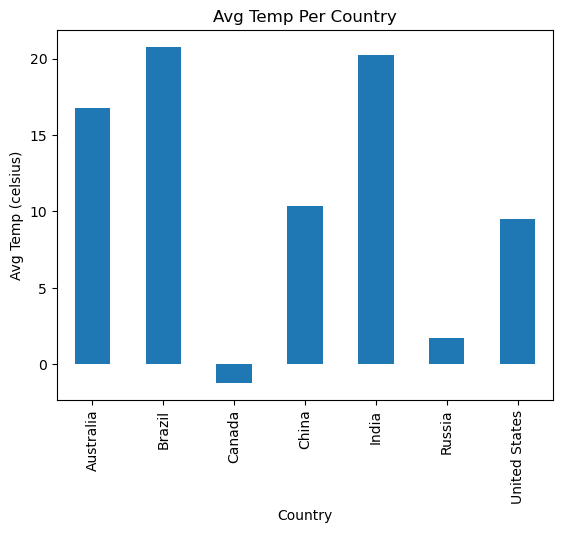

In [40]:
train.groupby('country')['average_temp'].mean().plot.bar()
plt.title('Avg Temp Per Country')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Country')
plt.show()

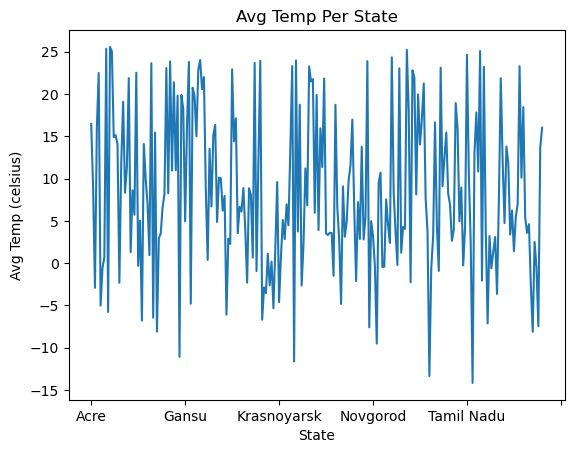

In [39]:
train.groupby('state')['average_temp'].mean().plot()
plt.title('Avg Temp Per State')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('State')
plt.show()

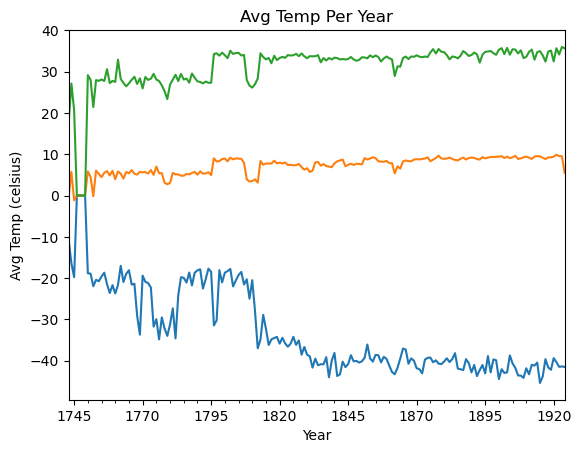

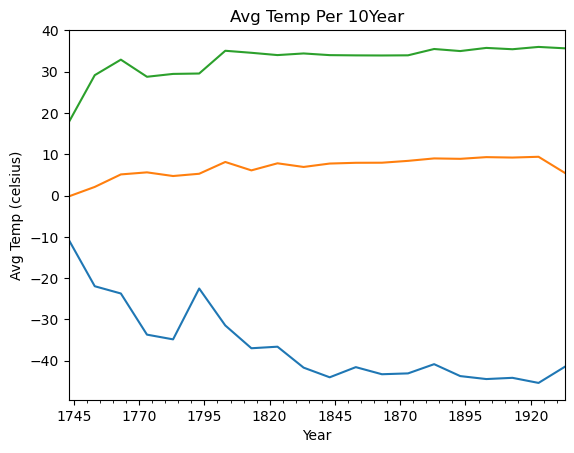

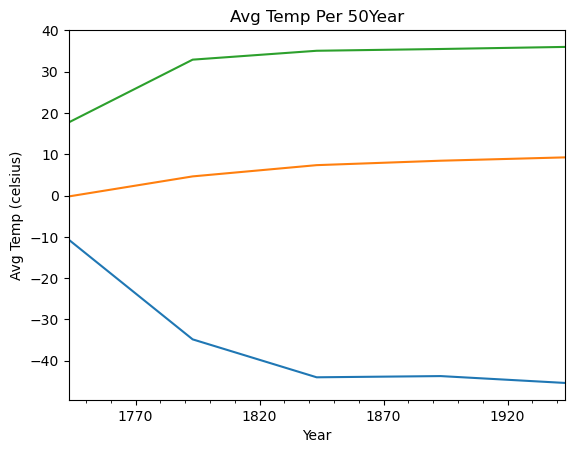

In [48]:
train.resample('Y').min()['average_temp'].plot()
train.resample('Y').mean()['average_temp'].plot()
train.resample('Y').max()['average_temp'].plot()
plt.title('Avg Temp Per Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()

train.resample('10Y').min()['average_temp'].plot()
train.resample('10Y').mean()['average_temp'].plot()
train.resample('10Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 10Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()

train.resample('50Y').min()['average_temp'].plot()
train.resample('50Y').mean()['average_temp'].plot()
train.resample('50Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 50Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()
